$\newcommand{\calf}{{\cal F}}
\newcommand{\calk}{{\cal K}}
\newcommand{\calp}{{\cal P}}
\newcommand{\dnu}{d \nu}
\newcommand{\mf}{{\bf F}}
\newcommand{\md}{{\bf D}}
\newcommand{\mP}{{\bf P}}
\newcommand{\mU}{{\bf U}}
\newcommand{\vu}{{\bf u}}
\newcommand{\vx}{{\bf x}}
\newcommand{\vw}{{\bf w}}
\newcommand{\vy}{{\bf y}}
\newcommand{\vf}{{\bf f}}
\newcommand{\vs}{{\bf s}}
\newcommand{\ve}{{\bf e}}
\newcommand{\vd}{{\bf d}}
\newcommand{\vb}{{\bf b}}
\newcommand{\vz}{{\bf z}}
\newcommand{\vr}{{\bf r}}
\newcommand{\mg}{{\bf G}}
\newcommand{\ml}{{\bf L}}
\newcommand{\mg}{{\bf G}}
\newcommand{\mv}{{\bf V}}
\newcommand{\ma}{{\bf A}}
\newcommand{\mi}{{\bf I}}
\newcommand{\mm}{{\bf M}}
\newcommand{\mb}{{\bf B}}
\newcommand{\ball}{{\cal B}}
\newcommand{\ptc}{{\Psi TC}}
\newcommand{\diag}{\mbox{diag}}
\newcommand{\begeq}{{\begin{equation}}}
\newcommand{\endeq}{{\end{equation}}}
$

In [1]:
include("fanote_init.jl")

┌ Info: Precompiling SIAMFANLEquations [084e46ad-d928-497d-ad5e-07fa361a48c4]
└ @ Base loading.jl:1317
┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1317
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1317
┌ Info: Precompiling NotebookSIAMFANL [top-level]
└ @ Base loading.jl:1317


# Chapter 3: Newton-Krylov Methods

## Contents for Chapter 3

[Section 3.1: Krylov Methods for Solving Linear Equations](#Section-3.1:-Krylov-Methods-for-Solving-Linear-Equations)

[Section 3.2: Preconditioning](#Section-3.2:-Preconditioning)

[Section 3.3: Computing an Approximate Newton Step](#Section-3.3:-Computing-an-Approximate-Newton-Step)

[Section 3.4: Pseudo-Transient Continuation](#Section-3.4:-Pseudo-Transient-Continuation)

[Section 3.5: What Can Go Wrong?](#Section-3.5:-What-Can-Go-Wrong?)

[Section 3.6: Newton-Krylov Examples](#Section-3.6:-Newton-Krylov-Examples)

Recall from section __1.4__ that an inexact Newton method
approximates the Newton direction with a vector $\vd$ satisfying the __inexact Newton condition__. This means that
$$
\| \mf'(\vx_n) \vd + F(\vx_n) \| \le \eta \| \mf(\vx_n) \|.
$$
 The parameter $\eta$ is called the
__forcing term__. 

Newton iterative methods realize the inexact Newton condition
by applying a linear iterative method to the
equation for the Newton step and terminating that iteration
when the inexact Newton condition holds. We sometimes refer to this linear iteration
as an __inner iteration__. Similarly,
the nonlinear iteration (the while loop in Algorithm __nsol__)
is often called the __outer iteration__.

The Newton-Krylov methods, as the name suggests, use Krylov
subspace-based linear solvers. The methods differ in storage
requirements, cost in evaluations of $F$, and robustness.
Our solver package __SIAMFANLEquations.jl__ has two
Newton-Krylov nonlinear solvers, __nsoli.jl__ and __ptcsoli.jl__.
We include two Krylov linear solvers,
GMRES 
<cite data-cite="gmres"><a href="siamfa.html#gmres">(SS86)</cite>
in the function __kl\_gmres.jl__ and
and BiCGSTAB 
<cite data-cite="bicgstab"><a href="siamfa.html#bicgstab">(vdV92)</cite>
in the function __kl\_bicgstab.jl__. Our linear solvers have been designed
to work well with nonlinear solvers. For example, information from the
nonlinear solver can be used to adjust the forcing term in the linear
solver. Following convention,
we will refer to the nonlinear methods as
Newton-GMRES and Newton-BiCGSTAB.


## Section 3.1: Krylov Methods for Solving Linear Equations

Krylov iterative
methods approximate the solution of a linear system $\ma \vx = \vb$
with a sum of the form
$$
\vx_k = \vx_0 + \sum_{j=0}^{k-1} \gamma_k \ma^k \vr_0,
$$
where $\vr_0 = \vb - \ma \vx_0$ and $\vx_0$ is the initial iterate.
If the goal is to approximate a Newton step, as it is here,
the most sensible initial iterate is $\vx_0 = 0$, because we
have no _a priori_ knowledge of the direction, but, at least
in the local phase of the iteration, expect it to be small.

We express this in compact form as $\vx_k \in {\cal K}_k$,
where the $k$th __Krylov subspace__ is
$$
{\cal K}_k = \mbox{span}(\vr_0, \ma \vr_0, \dots, \ma^{k-1} \vr_0 ).
$$
Krylov methods build the iteration by evaluating matrix-vector
products, in very different ways, to build an iterate in the
appropriate Krylov subspace. Our nonlinear solvers, like most
implementations of Newton-Krylov methods,
approximate Jacobian-vector products with forward
differences as the default. You have
the option of providing an analytic Jacobian-vector project. Unlike
the case for direct linear solvers, there is rarely any gain inK
performance or robustness in using an analytic Jacobian-vector product.
If you find that the iteration is stagnating, your first step should
be to reduce the forcing term. After that you
might see if an analytic Jacobian-vector product helps, but it is not
likely that it will.


### GMRES

The easiest Krylov method to understand is the GMRES
<cite data-cite="gmres"><a href="siamfa.html#gmres">(SS86)</cite>
method, the default linear solver in __nsoli.jl__. The
$k$th GMRES iterate is the solution of the linear least squares
problem of minimizing
$$
\| \vb - \ma \vx_k \|^2
$$
over ${\cal K}_k$.
We refer the reader to 
<cite data-cite="gmres"><a href="siamfa.html#gmres">(SS86)</cite>,
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>,
<cite data-cite="trefbau"><a href="siamfa.html#trefbau">(TB96)</cite>,
<cite data-cite="demmel"><a href="siamfa.html#demmel">(Dem97)</cite>,
for
the details of the implementation, pointing out only that it is
not a trivial task to implement GMRES well.

GMRES must accumulate the history of the linear iteration as an
orthonormal basis for the Krylov subspace. This is an important
property of the method because one can, and often does for large
problems, exhaust the available fast memory. Any implementation of
GMRES must limit the size of the Krylov subspace. GMRES($m$)
does this by restarting the iteration when the
size of the Krylov space exceeds $m$ vectors. With __nsoli.jl__
you must allocate storage of $m+1$ vectors for the Krylov basis for
GMRES($m$). The if you ask for more than $m$ GMRES iterations the iteration
will restart. The default is to take $m$ GMRES iterations or fewer before
termination. The convergence theory for GMRES does not
apply to GMRES($m$), so the performance of GMRES(m) can be poor if
$m$ is small.

GMRES, like other Krylov methods,
is often, but not always, implemented as a
__matrix-free__ method. The reason for this
is that only matrix-vector products, rather than details of the
matrix itself, are needed to implement a Krylov method. One example
of a matrix-free method is the use of a forward difference Jacobian-vector product.

#### Convergence of GMRES
    
As a general rule (but not an absolute law!
<cite data-cite="trefa"><a href="siamfa.html#trefa">(NRT92)</cite>),
GMRES, like other Krylov methods, performs best if the eigenvalues of
$\ma$ are in a few tight clusters 
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>,
<cite data-cite="ctk:jordan"><a href="siamfa.html#ctk:jordan">(CIKM96)</cite>,
<cite data-cite="trefbau"><a href="siamfa.html#trefbau">(TB96)</cite>,
<cite data-cite="demmel"><a href="siamfa.html#demmel">(Dem97)</cite>.

One way to understand this, keeping in mind that $\vx_0 = 0$, is
to observe that the $k$th GMRES residual is in ${\cal K}_k$ and hence
can be written as a polynomial in $\ma$ applied to the residual
$$
\vr_k = \vb - \ma \vx_k = p(\ma) \vr_0 = p(\ma) \vb.
$$
Here $p \in {\cal P}_k$, the set of $k$th-degree
__residual polynomials__. This is the
set of polynomials of degree $k$ with $p(0) = 1$. Since the $k$th
GMRES iteration satisfies
$$
\| \ma \vx_k - \vb \| \le \| \ma \vz - \vb \|
$$
for all $\vz \in \calk_k$, we must have 
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>
$$
\| \vr_k \| = \min_{p \in \calp_k} \| p(\ma) \vr_0 \|.
$$
This simple fact can lead to very useful error estimates.

Here, for example, is a convergence result for diagonalizable matrices.
$\ma$ is __diagonalizable__
if there is a nonsingular matrix $\mv$ such that
$$
\ma = \mv \Lambda \mv^{-1}.
$$
Here $\Lambda$ is a
diagonal matrix with the eigenvalues of $\ma$ on the
diagonal. If $\ma$ is a diagonalizable matrix
and $p$ is a polynomial, then
$$
p(\ma) = \mv p(\Lambda) \mv^{-1}.
$$
$\ma$ is __normal__
if
the __diagonalizing transformation__
$\mv$ is __unitary__.
In this case the columns of $\mv$ are
the eigenvectors of $\ma$ and $\mv^{-1} = \mv^H$. Here $\mv^H$ is the complex
conjugate transpose of $\mv$.
The reader should be aware that $\mv$ and $\Lambda$ can be complex even
if $\ma$ is real.

___
__Theorem 3.1.__ 
Let $\ma = \mv \Lambda \mv^{-1}$ be a nonsingular diagonalizable matrix.
Let $\vx_k$ be the $k$th GMRES iterate. Then, for all
$\bar p_k \in \calp_k$,
$$
\frac{\| \vr_k \|}{\| \vr_0 \|} \le \kappa_2(\mv)
\max_{z \in \sigma(\ma)} | {\bar p}_k(z) |.
$$
___
    
    
___
__Proof:__
Let $\bar p_k \in \calp_k$.
We can easily estimate $\| \bar p_k(\ma) \|$ by
$$
\| \bar p_k(\ma) \| \le \| \mf \| \| \mv^{-1} \| \| \bar p_k(\Lambda) \|
\le \kappa_2(\mv) \max_{z \in \sigma(\ma)} | \bar p_k(z) |,
$$
as asserted
___

    
Suppose, for example, that $\ma$ is diagonalizable,
$\kappa(\mv) = 100$, and all the eigenvalues of $A$ lie in a
disk of radius $0.1$ centered about $1$ in the complex plane.
The theorem above implies (using ${\bar p}_k(z) = (1 - z)^k$) that
$$
\| \vr_k \| \le 100 (0.1)^k = 0.1^{k-2}.
$$
Hence, GMRES will reduce the residual by a factor of, say, $10^5$ after
seven iterations. Since reduction of the residual is the goal of the
linear iteration in an inexact Newton method, this is a very useful
bound. See 
<cite data-cite="ctk:jordan"><a href="siamfa.html#ctk:jordan">(CIKM96)</cite>
    for examples of similar estimates when
the eigenvalues are contained in a small number of clusters.
One objective of  preconditioning (see section 3.2)
is to change $\ma$ to obtain an advantageous
distribution of eigenvalues.


### Section 3.1.2: Low Storage Krylov Methods

If $\ma$ is symmetric and positive definite, the conjugate gradient
(CG)
\index{Conjugate gradient method}
method \cite{cg} has better convergence and storage properties
than the more generally applicable Krylov methods. In exact arithmetic
the $k$th CG iteration minimizes
$$
(\vx - \vx^*)^T \ma (\vx - \vx^*) = \ve^T \ma \ve = \| \ve \|_A^2
$$
over the $k$th Krylov subspace. The symmetry and positivity
can be exploited so that the storage requirements do not grow with the
number of iterations.

A tempting idea is to multiply a general system $\ma \vx = \vb$
by $\ma^T$ to obtain the
__normal equations__ $\ma^T \ma \vx = \ma^T \vb$ and then apply CG to
the new problem, which has a symmetric positive definite
coefficient matrix $A^T\!A$. This
approach, called CGNR, has
the disadvantage that the condition number of $\ma^T \ma$ is the square
of that of $\ma$, and hence the convergence of the CG iteration can
be far too slow. A similar approach,
called CGNE, solves $\ma \ma^T \vz = \vb$
with CG and then sets $\vx = \ma^T \vz$. Because the condition number is
squared and a transpose-vector multiplication is needed, CGNR and CGNE
are used far less frequently than the other low-storage methods.

The need for a transpose-vector multiplication is a major problem
unless one wants to store the Jacobian matrix. It is simple, as we have seen,
to approximate a Jacobian-vector
product with a forward difference, but no matrix-free way to
obtain a transpose-vector product is known.

Low-storage alternatives to GMRES that do not need a transpose-vector
product are available 
<cite data-cite="bicgstab"><a href="siamfa.html#bicgstab">(vdV92)</cite>,
<cite data-cite="tfqmr"><a href="siamfa.html#tfqmr">(Fre93)</cite>,
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>,

but do not
have the robust theoretical properties of GMRES or CG.
Aside from GMRES($m$), one such low-storage solvers, BiCGSTAB 
<cite data-cite="bicgstab"><a href="siamfa.html#bicgstab">(vdV92)</cite> 
can be used in __nsoli.jl__.

We refer the reader to 
<cite data-cite="bicgstab"><a href="siamfa.html#bicgstab">(vdV92)</cite>,
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>, and
<cite data-cite="anne"><a href="siamfa.html#anne">(Gre97)</cite>
for detailed descriptions of this and other low-storage methods. If you consider
BiCGSTAB and or GMRES(m) as solvers, you should be aware that,
while both have the advantage of a fixed storage requirement
throughout the linear iteration, there are some problems.

BiCGSTAB can __break down__. This means that
the iteration will cause a division by zero. This is not an
artifact of the floating point number system but is
intrinsic to the methods.  While GMRES($m$)
can also fail to converge, that failure will manifest itself
as a stagnation in the iteration, not a division by zero or
an overflow.

The number of linear iterations that BiCGSTAB
needs for convergence can be roughly the same as for GMRES, but each
linear iteration needs two matrix-vector products (i.e., two
new evaluations of $\mf$).

GMRES($m$) should be your first choice and is built into
__kl\_gmres.jl__ and therefore into __nsoli.jl__ and __ptcsoli.jl__.
If, however, you cannot
allocate the storage that GMRES($m$) needs to perform well,
BiCGSTAB as implemented in __kl\_bicgstab.jl__, is also accessible from
__nsoli.jl__ and  __ptcsoli.jl__ and
may solve your problem.

If you can store
the Jacobian, or can compute a transpose-vector product in an
efficient way, and the Jacobian is well conditioned, applying
the conjugate gradient
(CG) iteration to the normal equations can be
a good idea. While the cost of a single iteration is two matrix-vector
products, convergence, at least in exact arithmetic,
is guaranteed 
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>, and
<cite data-cite="anne"><a href="siamfa.html#anne">(Gre97)</cite>.   



## Section 3.2: Preconditioning

__Preconditioning__ the matrix $\ma$ means
multiplying $\ma$ from the right, left, or both sides by a
__reconditioner__ $\mm$. One does this with the expectation that
systems with the coefficient matrix $\ma \mm$ or $\ma \mm$ are easier to
solve than those with $\ma$. Of course, preconditioning can be done
in a matrix-free manner. One needs only a
function that performs a preconditioner-vector product.

__Left preconditioning__ multiplies the
equation $\ma \vx = \vb$ on both sides by $M$ to obtain the
__preconditioned system__ $\mm \ma \vx = \mm \vb$.
One then applies the Krylov
method to the preconditioned system. If the condition number of
$\mm \ma$ is really smaller than that of $\ma$,
the residual of the preconditioned
system will be a better reflection of the error than that of the original
system. One would hope so, since the preconditioned residual will be used
to terminate the linear iteration.

__Right preconditioning__ solves the
system $\ma \mm \vy = \vb$ with the Krylov method. Then the solution of the
original problem is recovered by setting $\vx = \mm \vy$.
Right preconditioning
has the feature that the residual upon which termination is based is
the residual for the original problem.

Two-sided preconditioning replaces $\ma$ with
$\mm_{left} \ma \mm_{right}$.

A different approach, which is integrated into some
initial value problem codes 
<cite data-cite="brownh86"><a href="siamfa.html#brownh86">(BH86)</cite>,
<cite data-cite="brown/daskp"><a href="siamfa.html#brown/daspk">(BHP94)</cite>, is to
pretend that the Jacobian is banded, even if it isn't,
and to use Jacobian-vector products and the forward
difference method for banded Jacobians 
to form a banded approximation to the Jacobian.
One factors the banded approximation and uses that
factorization as the preconditioner.

### Section 3.2.1 Preconditioners

This section is not an exhaustive account of preconditioning
and is only intended to point the reader to the literature.

Ideally the preconditioner should be close to the
inverse of the Jacobian. In practice, one can get away with
far less. If your problem is a discretization of an elliptic
differential
equation, then the inverse of the high-order part of the differential
operator (with the correct boundary conditions) is an
excellent preconditioner 
<cite data-cite="manpart"><a href="siamfa.html#manpart">(MP90)</cite>.
If the high-order term
is linear, one might be able to
compute the preconditioner-vector product
rapidly with, for example, a fast transform method
 or a multigrid iteration 
<cite data-cite="mgtut2"><a href="siamfa.html#mgtut2">(BHM00)</cite>.
Multigrid methods exploit the smoothing properties of the
classical stationary iterative methods by mapping the equation
through a sequence of grids. When multigrid methods are used as a solver,
one can often show that a solution can be obtained at a cost of
$O(N)$ operations, where $N$ is the number of unknowns. Multigrid
implementation is difficult and a more typical application is
to use a single multigrid iteration (for the high-order term)
as a preconditioner.

Domain decomposition preconditioners 
<cite data-cite="domain"><a href="siamfa.html#domain">(SBG96)</cite>,
<cite data-cite="olofdd"><a href="siamfa.html#olofdd">(TW05)</cite>,
<cite data-cite="qvdd"><a href="siamfa.html#qbdd">(QV99)</cite>,
approximate the inverse of the high-order term (or the entire operator)
by subdividing the geometric domain of the
differential operator, computing the inverses on the subdomains,
and combining those inverses. When implemented in an optimal way,
the condition number of the preconditioned matrix is independent of
the discretization mesh size.

Algebraic preconditioners use the sparsity structure of the Jacobian
matrix. This is important, for example, for problems that do not
come from discretizations of differential or integral equations
or for discretizations of differential equations on unstructured
grids, which may be generated by computer programs.
    
An example of such a preconditioner is
__algebraic multigrid__ (AMG), which is designed for discretized
differential equations on unstructured grids
<cite data-cite="yangamg"><a href="siamfa.html#yangamg">(Yan06)</cite>.
Algebraic multigrid attempts to recover geometric information from
the sparsity pattern of the Jacobian and thereby simulate
the intergrid transfers and smoothing used in a conventional
geometric multigrid preconditioner. The package
__AlgebraicMultigrid.jl__ 
<cite data-cite="amgjl"><a href="siamfa.html#amgjl">(Ana21)</cite>
implements several variations
of AMG.

Another algebraic
approach is 
__incomplete factorization__
<cite data-cite="ilu"><a href="siamfa.html#ilu">(Saa96)</cite>,
<cite data-cite="saadaxeqb"><a href="siamfa.html#saadaxeqb">(Saa96b)</cite>. 
Incomplete factorization preconditioners
compute a factorization of a sparse matrix but do not store those elements
in the factors that are too small or lie outside a prescribed
sparsity pattern. These preconditioners
require that the Jacobian be stored as a sparse matrix.
The Julia Packages __ILUZero.jl__ 
<cite data-cite="ilu0jl"><a href="siamfa.html#ilu0jl">(Cov21)</cite> and
__IncompleteLU.jl__ 
<cite data-cite="ilujl"><a href="siamfa.html#ilujl">(Sto21)</cite>
implement incomplete LU factorizations.



## Section 3.3: Computing an Approximate Newton Step

### Section 3.3.1: Jacobian-Vector Products

For nonlinear
equations, the Jacobian-vector product is easy to approximate with
a forward difference directional derivative.
The forward difference directional derivative at $x$ in the direction
$w$ is
$$
D_h \mf(\vx:\vw) = \left\{
\begin{array}{ll}
0, & \vw = 0,\\
\\
\| \vw \|
\dfrac{\mf(\vx + h \vw /\| \vw \| ) - \mv(\vx)}{h}, & \vw \ne 0.
\end{array}
\right.
$$
The scaling is important.
We first scale $\vw$ to be a unit vector and
take a numerical directional derivative in the direction $\vw/\| \vw \|$.
If $h$ is roughly the square root
of the error in $\mf$, we use a difference increment in
the forward difference to make sure that the appropriate low-order bits
of $\vx$ are perturbed.
The same scaling was used in the
forward difference Jacobian in Chapter 2.

### Section 3.3.2: Preconditioning for Nonlinear Equations

Our Newton-Krylov solver __nsoli.jl__
allows you to apply a preconditioner on
either the left or right by a preconditioner-vector
product function. This is simpler and more direct that the approach
from 
<cite data-cite="ctk:newton"><a href="siamfa.html#ctk:newton">(Kel03)</cite>,
where the matlab code
expects you to incorporate preconditioning into
$\mf$. We explain that approach later in this section.

We will warn you now, and go in to details later,
that only right preconditioning makes sense for $\ptc$.



#### Left or Right Preconditioning?

Right preconditioning has a
significant advantage in Newton-Krylov methods because the residual
is the same residual used in the inexact Newton condition. If one uses
left preconditioning one may terminate on a Newton step that fails to
satisfy the inexact Newton condition for the unpreconditioned problem and
affect the performance of the line search.

__Left preconditioning__
will terminate the iteration when
$\| \mm \mf'(\vx) \vd + \mm \mf(\vx) \|$
is small. If
$\mm$ is a good approximation to $\mf'(\vx^*)^{-1}$, then
$$
\vd \approx - \mm \mf'(\vx^*) \ve \approx - \ve
$$
and so one might expect a better Newton step which
captures the actual error. However, the meaning of
the inexact Newton condition for left preconditioning is not
completely clear.

On the
other hand, if one uses 
__right preconditioning__, then the linear iteration will
terminate when
$\| \mf'(\vx) \vd + \mf(\vx) \|$ is
small, reflecting the inexact Newton condition and
responding to the
problem statement 
"Make the linear residual small",
which corresponds exactly to the inexact Newton condition
 and __Theorem 1.4__ for
convergence of inexact Newton methods.

#### Preconditioning the Nonlinear Problem

One can sometime code the combination of preconditioner and
nonlinear residual more efficiently that doing them separately.
To precondition the equation for the Newton step from the left, one
would
simply apply __nsoli.jl__ to the preconditioned nonlinear problem
$$
\mg(\vx) = \mm \mf(\vx) = 0.
$$
The equation for the Newton step for $\mg is
$$
\mg'(\vx) \vd = \mm \mf'(\vx) \vd = - \mg (\vx) = - \mm \mf(\vx),
$$
which is the left-preconditioned equation for the Newton direction
for $\mf$.

Left preconditioning makes more sense if one is preconditioning the
nonlinear problem. The reason for this is that the line search is applied
to the preconditioned problem, which is not the case if one preconditions
the linear solver. The examples in 
<cite data-cite="ctk:newton"><a href="siamfa.html#ctk:newton">(Kel03)</cite>
make left preconditioning look a bit too good for exactly this reason.
We will revisit this issue in the examples in __section 3.6__.

In nonlinear right preconditioning
we set $\vx = \mm {\tilde \vy}$ and solve
$$
\mg(\vy) = \mf(\mm \vy) = 0
$$
with Newton's method. The equation for the direction
${\tilde \vd}$ is
$$
\mg'(\vy) {\tilde \vd}
= \mf'(\mm \vy) \mm {\tilde \vd} = -\mg(\vy) = - \mf(\mm \vy),
$$
which is exactly the right-preconditioned equation for the step.
Hence right preconditioning for the nonlinear problem produces the
same iteration as solving the original problem and using right
preconditioning for the linear equation for the Newton direction.

Preconditioning for $\ptc$ is a different story and we cover that in
__section 3.4__.

### Section 3.3.3: Choosing the Forcing Term

One should take care to chose a forcing term that is not too small at
the beginning of the iteration. For example, setting $\eta = 10^{-8}$
for the entire iteration will lead to a low number of nonlinear iterations.
However, one will be taking far to much time on linear solves early on.
If one wants to fix $\eta$, the author's favorite approach, a more sensible
value is $\eta = .1$, which is the default in __nsoli.jl}__ Once again,
$\ptc$ is different and a smaller forcing term, especially at the beginning,
may be needed to track the dynamics.
Having said all that, we must also discuss a very clever alternative for
Newton's method.

The Eisenstat-Walker (EW)
approach from <cite data-cite="homerstan"><a href="siamfa.html#homerstan">(EW94)</cite>
changes the forcing term $\eta$
 as
the nonlinear iteration progresses. The formula is complex
and motivated by a lengthy story, which we condense from
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>.
The overall goal in <cite data-cite="homerstan"><a href="siamfa.html#homerstan">(EW94)</cite>
is to solve the linear
equation for the Newton step to just enough precision to
make good progress when far from a solution, but also to
obtain quadratic convergence when near a solution. One might
base a choice of $\eta$ on residual norms; one way to do
this is
$$
\eta_n^{Res} = \gamma \| \mf(\vx_n)\|^2/\| F(\vx_{n-1})\|^2,
$$
where $\gamma \in (0,1]$ is a parameter. If $\eta_n^{Res}$ is bounded
away from $1$ for the entire iteration, the choice $\eta_n = \eta_n^{Res}$
will do the job, assuming we make a good choice for $\eta_0$. To
make sure that $\eta_n$ stays well away from $1$, we can simply
limit its maximum size.
Of course, if $\eta_n$ is too small in the early stage of
the iteration,
then the linear equation for the Newton step can be solved
to far more precision than is really needed. To protect against
__oversolving__, a method of
__safeguarding__ was proposed in <cite data-cite="homerstan"><a href="siamfa.html#homerstan">(EW94)</cite>
to avoid volatile decreases in $\eta_n$. The idea is that if
$\eta_{n-1}$ is sufficiently large, we do not let $\eta_n$ decrease
by too much; <cite data-cite="homerstan"><a href="siamfa.html#homerstan">(EW94)</cite>
suggests limiting the decrease to
a factor of $\eta_{n-1}$.
    
After taking all this into account, one finally arrives at 
<cite data-cite="ctk:roots"><a href="siamfa.html#ctk:roots">(Kel95)</cite>    
$$
\eta_n = \min( \eta_{max}, \max(\eta_n^{Safe},
0.5 \tau_t/\| \mf(\vx_n)\| ) ).
$$
The term
$$
\tau_t = \tau_a + \tau_r \| \mf(\vx_0) \|
$$
is the termination tolerance for the nonlinear iteration and is
included in the formula to prevent oversolving on the final iteration.
$\eta_{max}$ is an upper limit on the forcing term and
$$
\eta_n^{Safe} = \left\{
\begin{array}{ll}
\eta_{max}, & n = 0,\\
\\
\min(\eta_{max}, \eta_n^{Res} ), & n > 0, \gamma  \eta_{n-1}^2 \le 0.1,\\
\\
\min(\eta_{max}, \max(\eta_n^{Res}, \gamma  \eta_{n-1}^2) ), &
n > 0, \gamma  \eta_{n-1}^2 > 0.1,\\
\end{array}
\right.
$$
    
In <cite data-cite="homerstan"><a href="siamfa.html#homerstan">(EW94)</cite> 
    $\gamma=0.9$ and $\eta_{max} = 0.9999$ are used. In __nsoli.jl__
we set $\gamma = .9$. You can specify $\eta_{max}$ in the call to
__nsoli.jl__.


## Section 3.4: Pseudo-Transient Continuation

## Section 3.5: What Can Go Wrong?

## Section 3.6: Newton-Krylov Examples

### Chandrasekhar H-Equation

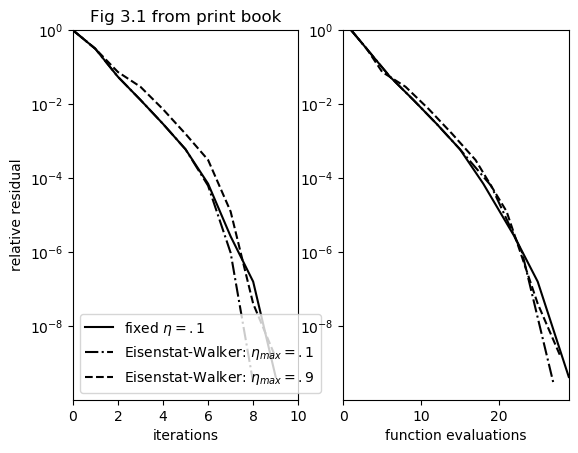

In [2]:
nk_heq_forcing();

### Convection-Diffusion Equation

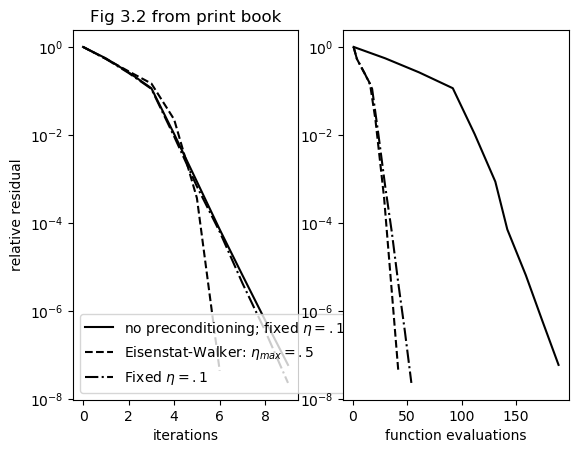

In [3]:
nk_pde_forcing();

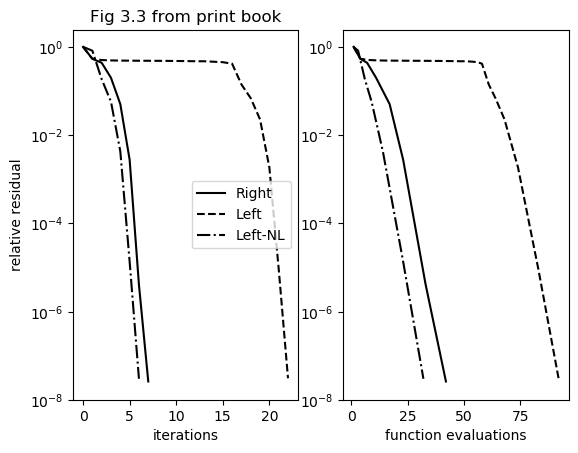

In [4]:
sideout=nk_pde_side();

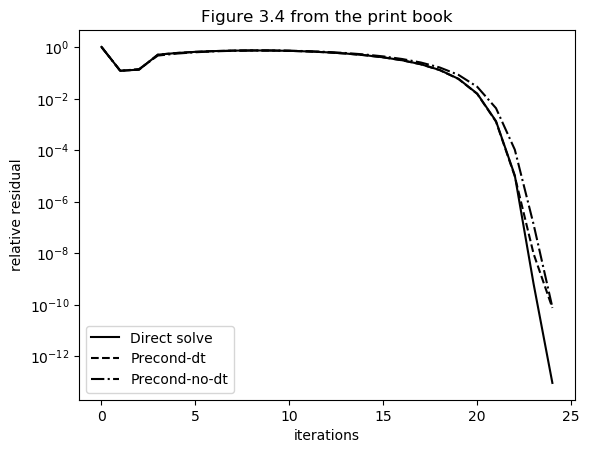

In [5]:
ptcCompare();

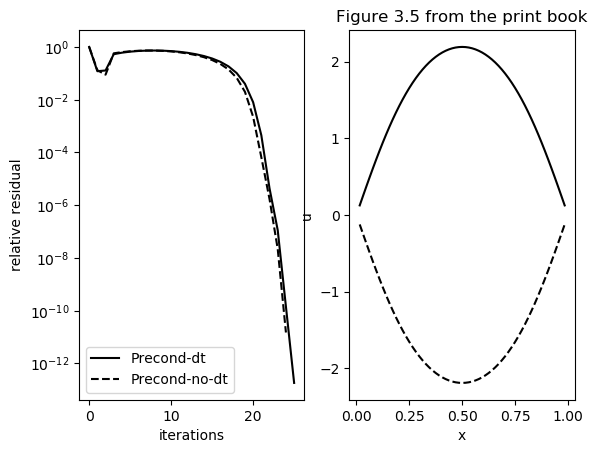

In [6]:
LptcCompare();

## Next notebook = [Section 3.7: Solvers for Chapter 3](SIAMFANLCh3s.ipynb)